# IT1244 Project

## Import Libraries

In [2]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
import torch as torch
from transformers import AutoModel
from transformers import AutoTokenizer, BertTokenizerFast
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [3]:
def accuracy_score(y_test, y_pred):
    return sum(y_test == y_pred)/len(y_test)

In [4]:
def metrics(y_true, y_guess, table = False, model_name = "", digits=4):
    CM = confusion_matrix(y_true, y_guess)
    TN, FN, TP, FP =  CM[0][0], CM[1][0], CM[1][1], CM[0][1]
    accuracy = np.round((TP+TN)/(TP+TN+FP+FN), digits)
    precision = np.round(TP/(TP+FP), digits)
    recall =  np.round(TP/(TP+FN), digits)
    f1_score =  np.round(2*(precision*recall)/(precision+recall), digits)
    if not table:
        return accuracy, precision, recall, f1_score
    else:
        if not model_name:
            return pd.DataFrame({'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1_score': [f1_score]})
        else:
            return pd.DataFrame({'model':[model_name], 'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1_score': [f1_score]})

## Data Importing

In [5]:
tweets = pd.read_csv("../Data/Raw/dataset.csv", header=None)
tweets.head()

0                                                  1
0  0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1  0  is upset that he can't update his Facebook by ...
2  0  @Kenichan I dived many times for the ball. Man...
3  0    my whole body feels itchy and like its on fire 
4  0  @nationwideclass no, it's not behaving at all....

### Bert Encoding

Citation  

We use BERT encoding to represent each tweet into a vector according to contextual meaning of the tweet.  
Anggrainingsih, R., Hassan, G. M., & Datta, A. (2021, September 7). BERT based classification system for detecting rumours on Twitter. arXiv.org. https://arxiv.org/abs/2109.02975

In [17]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)
model = AutoModel.from_pretrained('vinai/bertweet-base')

In [6]:
def bert_encode(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state[:, 0, :]


In [ ]:
## Due to the large size, the download link to the encoded csv file is provided in Data/Cleaned/BERT_vectors.txt

sentence_vectors = tweets[1].apply(lambda x: bert_encode(x))
data = np.array(list(map(lambda x: x[0], sentence_vectors)))
data_frame = pd.DataFrame(data)
data_frame.to_csv("../Data/Cleaned/BERT_Vectors.csv")

### Read the CSV data file

In [6]:
Bert_Encoded_Text = pd.read_csv("../Data/Cleaned/BERT_Vectors.csv").iloc[: , 1:]
X = Bert_Encoded_Text
y = tweets[0]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Deep Learning Neural Network

In [7]:
def accuracy_val(model):
    y_hat = model.predict(X_test)
    return float((sum((y_hat >= 0.5) == y_test)/len(y_test))[0])*100

In [8]:
def accuracy_train(model):
    y_hat = model.predict(X_train)
    return float((sum((y_hat >= 0.5) == y_train)/len(y_train))[0])*100

In [9]:
X.shape

(100000, 768)

In [10]:
y = np.array(y)
y = y.reshape(-1, 1)
y.shape

(100000, 1)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, tweets[0], test_size=0.2, random_state=42)

In [93]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='gelu'))
model.add(Dense(512, activation='gelu'))
model.add(Dense(512, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.7576 - loss: 0.4930 - val_accuracy: 0.8133 - val_loss: 0.4145
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8325 - loss: 0.3745 - val_accuracy: 0.8111 - val_loss: 0.4203
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8573 - loss: 0.3258 - val_accuracy: 0.8123 - val_loss: 0.4325
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8806 - loss: 0.2756 - val_accuracy: 0.8023 - val_loss: 0.4577
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9119 - loss: 0.2104 - val_accuracy: 0.7985 - val_loss: 0.5020
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9386 - loss: 0.1538 - val_accuracy: 0.7956 - val_loss: 0.6850
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9574 - loss: 0.1119 - val_accuracy: 0.7916 - val_loss: 0.7673
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9653 -

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - accuracy: 0.7390 - loss: 0.5159 - val_accuracy: 0.8040 - val_loss: 0.4314
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.8263 - loss: 0.3826 - val_accuracy: 0.8076 - val_loss: 0.4233
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.8532 - loss: 0.3380 - val_accuracy: 0.8064 - val_loss: 0.4288
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.8762 - loss: 0.2911 - val_accuracy: 0.8032 - val_loss: 0.4502
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9020 - loss: 0.2433 - val_accuracy: 0.7924 - val_loss: 0.5033
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9276 - loss: 0.1875 - val_accuracy: 0.7881 - val_loss: 0.5785
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9502 - loss: 0.1334 - val_accuracy: 0.7826 - val_loss: 0.6962
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 

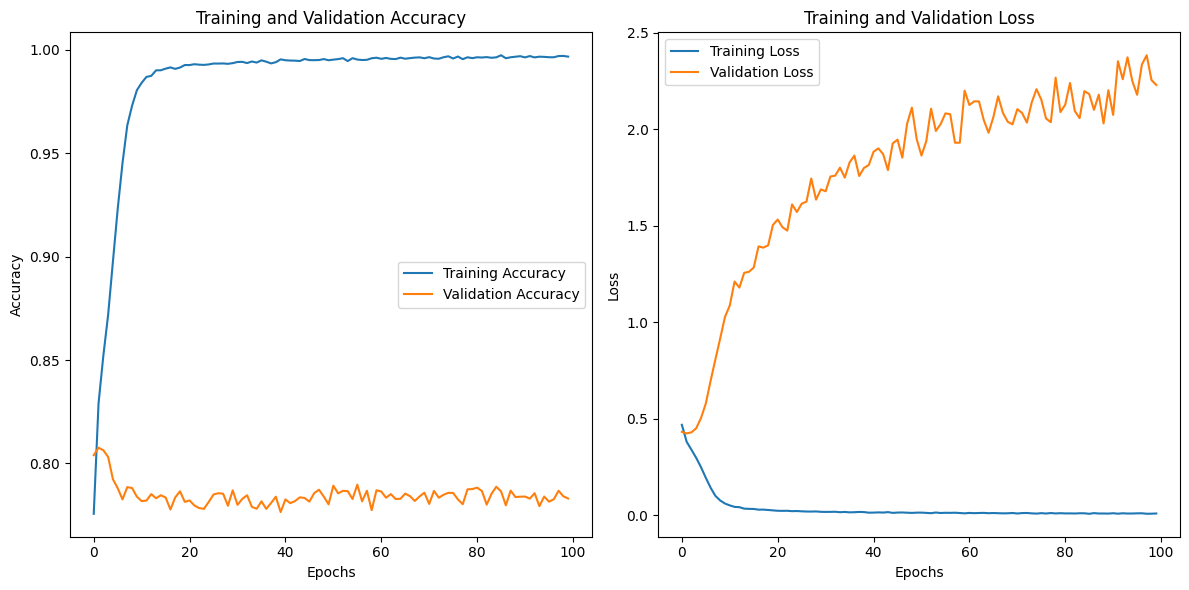

In [76]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model00 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model00.add(Dense(512, input_dim=768, activation='gelu'))
model00.add(Dense(512, activation='gelu'))
model00.add(Dense(512, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model00.add(Dense(1, activation='sigmoid'))

# Compile the model
model00.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=100,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)

# Train the model and save the history
history = model00.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Plot training accuracy and validation loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


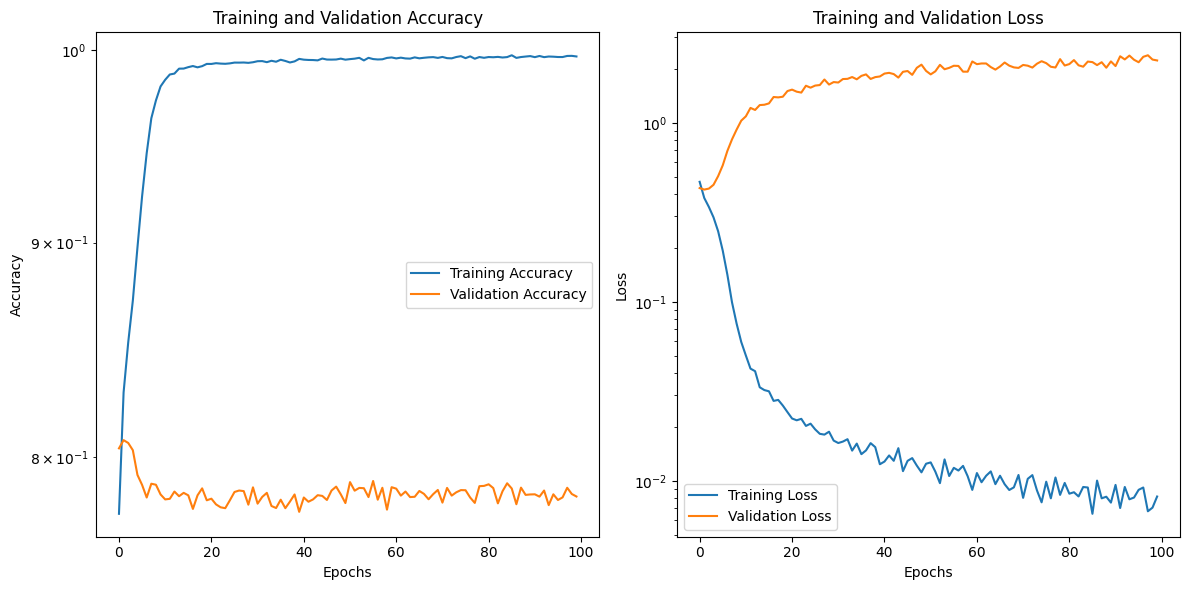

In [77]:
# Plot training accuracy and validation loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yscale('log')  # <-- Log scale for accuracy
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # <-- Log scale for loss
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


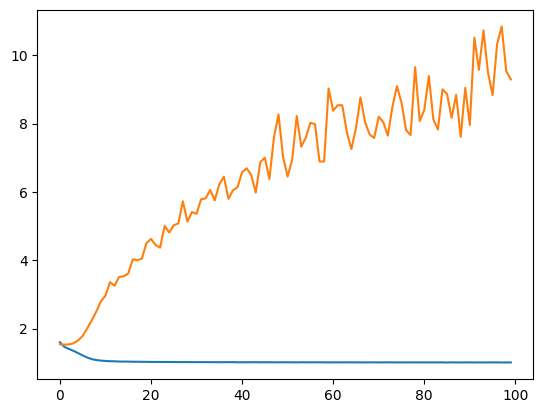

In [82]:
# For example: apply exp to the loss values
import numpy as np

exp_loss = np.exp(history.history['loss'])
exp_val_loss = np.exp(history.history['val_loss'])

plt.plot(exp_loss, label='Exp(Training Loss)')
plt.plot(exp_val_loss, label='Exp(Validation Loss)')



In [14]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7069 - loss: 0.5599 - val_accuracy: 0.8022 - val_loss: 0.4318
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8027 - loss: 0.4272 - val_accuracy: 0.8119 - val_loss: 0.4132
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8180 - loss: 0.4003 - val_accuracy: 0.8133 - val_loss: 0.4122
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8292 - loss: 0.3796 - val_accuracy: 0.8194 - val_loss: 0.4044
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8362 - loss: 0.3700 - val_accuracy: 0.8204 - val_loss: 0.4013
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8358 - loss: 0.3643 - val_accuracy: 0.8186 - val_loss: 0.4059
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8414 - loss: 0.3533 - val_accuracy: 0.8186 - val_loss: 0.4090
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8480 -

In [15]:
accuracy_val(model)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


81.99

In [16]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model0 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model0.add(Dense(512, input_dim=768, activation='gelu'))
model0.add(Dropout(0.3))  # Dropout to prevent overfitting
model0.add(Dense(256, activation='gelu'))
model0.add(Dropout(0.3))
model0.add(Dense(128, activation='gelu'))
model0.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model0.add(Dense(1, activation='sigmoid'))

# Compile the model
model0.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model0.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7241 - loss: 0.5439 - val_accuracy: 0.8026 - val_loss: 0.4336
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8087 - loss: 0.4193 - val_accuracy: 0.8156 - val_loss: 0.4115
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8297 - loss: 0.3840 - val_accuracy: 0.8166 - val_loss: 0.4107
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8330 - loss: 0.3749 - val_accuracy: 0.8160 - val_loss: 0.4042
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8407 - loss: 0.3592 - val_accuracy: 0.8215 - val_loss: 0.4009
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8457 - loss: 0.3512 - val_accuracy: 0.8198 - val_loss: 0.4027
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8528 - loss: 0.3361 - val_accuracy: 0.8172 - val_loss: 0.4049
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8578 -

In [17]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model1 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model1.add(Dense(512, input_dim=768, activation='relu'))
model1.add(Dropout(0.3))  # Dropout to prevent overfitting
model1.add(Dense(256, activation='gelu'))
model1.add(Dropout(0.3))
model1.add(Dense(128, activation='mish'))
model1.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.7234 - loss: 0.5411 - val_accuracy: 0.8073 - val_loss: 0.4258
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8132 - loss: 0.4146 - val_accuracy: 0.8118 - val_loss: 0.4148
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8231 - loss: 0.3927 - val_accuracy: 0.8199 - val_loss: 0.4068
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8333 - loss: 0.3780 - val_accuracy: 0.8175 - val_loss: 0.4033
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8389 - loss: 0.3645 - val_accuracy: 0.8198 - val_loss: 0.4017
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8438 - loss: 0.3514 - val_accuracy: 0.8177 - val_loss: 0.4054
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8474 - loss: 0.3483 - val_accuracy: 0.8216 - val_loss: 0.4035
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8514 -

In [18]:
accuracy_val(model1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


82.09

In [19]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model2 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model2.add(Dense(512, input_dim=768, activation='gelu'))
model2.add(Dropout(0.3))  # Dropout to prevent overfitting
model2.add(Dense(256, activation='gelu'))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='gelu'))
model2.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=AdamW(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7329 - loss: 0.5354 - val_accuracy: 0.8056 - val_loss: 0.4299
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8115 - loss: 0.4171 - val_accuracy: 0.8171 - val_loss: 0.4162
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8251 - loss: 0.3931 - val_accuracy: 0.8150 - val_loss: 0.4085
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8297 - loss: 0.3830 - val_accuracy: 0.8203 - val_loss: 0.4050
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8341 - loss: 0.3696 - val_accuracy: 0.8181 - val_loss: 0.4131
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8391 - loss: 0.3608 - val_accuracy: 0.8181 - val_loss: 0.4087
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8448 - loss: 0.3504 - val_accuracy: 0.8191 - val_loss: 0.4098
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8455 -

In [20]:
accuracy_val(model2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


81.875

In [21]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model3 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model3.add(Dense(512, input_dim=768, activation='gelu'))
model3.add(Dense(512, input_dim=768, activation='mish'))
model3.add(Dropout(0.3))  # Dropout to prevent overfitting
model3.add(Dense(256, activation='gelu'))
model3.add(Dense(256, activation='tanh'))
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='gelu'))
model3.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer=AdamW(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8327 - loss: 0.3805 - val_accuracy: 0.8204 - val_loss: 0.4070
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8410 - loss: 0.3609 - val_accuracy: 0.8228 - val_loss: 0.4072
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8441 - loss: 0.3542 - val_accuracy: 0.8164 - val_loss: 0.4174
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8463 - loss: 0.3448 - val_accuracy: 0.8189 - val_loss: 0.4193
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8518 - loss: 0.3339 - val_accuracy: 0.8188 - val_loss: 0.4175
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8572 - loss: 0.3249 - val_accuracy: 0.8166 - val_loss: 0.4160
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8591 - loss: 0.3175 - val_accuracy: 0.8158 - val_loss: 0.4224
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8613 -

In [22]:
accuracy_val(model3)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


49.75

In [23]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model4 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model4.add(Dense(512, input_dim=768, activation='mish'))
model4.add(Dropout(0.3))  # Dropout to prevent overfitting
model4.add(Dense(256, activation='tanh'))
model4.add(Dropout(0.3))
model4.add(Dense(128, activation='gelu'))
model4.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer=AdamW(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model4.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7385 - loss: 0.5238 - val_accuracy: 0.8076 - val_loss: 0.4244
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8128 - loss: 0.4129 - val_accuracy: 0.8127 - val_loss: 0.4113
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8207 - loss: 0.3942 - val_accuracy: 0.8117 - val_loss: 0.4183
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8304 - loss: 0.3792 - val_accuracy: 0.8184 - val_loss: 0.3999
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8354 - loss: 0.3679 - val_accuracy: 0.8181 - val_loss: 0.4073
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8381 - loss: 0.3631 - val_accuracy: 0.8214 - val_loss: 0.4053
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8415 - loss: 0.3553 - val_accuracy: 0.8216 - val_loss: 0.4049
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8476 -

In [24]:
accuracy_val(model4)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


82.27499999999999

In [25]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model5 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model5.add(Dense(64, input_dim=768, activation='mish'))
model5.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7175 - loss: 0.5710 - val_accuracy: 0.8071 - val_loss: 0.4267
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8076 - loss: 0.4191 - val_accuracy: 0.8116 - val_loss: 0.4144
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8197 - loss: 0.3993 - val_accuracy: 0.8144 - val_loss: 0.4091
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8275 - loss: 0.3867 - val_accuracy: 0.8164 - val_loss: 0.4049
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8322 - loss: 0.3811 - val_accuracy: 0.8203 - val_loss: 0.4005
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8348 - loss: 0.3710 - val_accuracy: 0.8174 - val_loss: 0.4038
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8364 - loss: 0.3692 - val_accuracy: 0.8194 - val_loss: 0.4016
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8404 - loss: 0.3646 

In [26]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model6 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model6.add(Dense(64, input_dim=768, activation='gelu'))
model6.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model6.add(Dense(1, activation='sigmoid'))

# Compile the model
model6.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model6.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7200 - loss: 0.5598 - val_accuracy: 0.8032 - val_loss: 0.4320
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8067 - loss: 0.4196 - val_accuracy: 0.8146 - val_loss: 0.4131
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8213 - loss: 0.3997 - val_accuracy: 0.8176 - val_loss: 0.4064
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8301 - loss: 0.3818 - val_accuracy: 0.8186 - val_loss: 0.4044
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8321 - loss: 0.3776 - val_accuracy: 0.8161 - val_loss: 0.4059
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8332 - loss: 0.3725 - val_accuracy: 0.8193 - val_loss: 0.3999
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8366 - loss: 0.3704 - val_accuracy: 0.8186 - val_loss: 0.4012
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8404 - loss: 0.3626 

In [27]:
from tensorflow.keras.regularizers import l1_l2

model7 = Sequential()
model7.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model7.add(Dropout(0.3))  # Dropout to prevent overfitting
model7.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model7.add(Dense(1, activation='sigmoid'))

# Compile the model
model7.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model7.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6372 - loss: 2.8766 - val_accuracy: 0.7523 - val_loss: 0.6908
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6647 - loss: 0.6931 - val_accuracy: 0.7606 - val_loss: 0.6443
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6614 - loss: 0.6721 - val_accuracy: 0.7658 - val_loss: 0.6361
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6690 - loss: 0.6663 - val_accuracy: 0.7713 - val_loss: 0.6297
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6720 - loss: 0.6590 - val_accuracy: 0.7728 - val_loss: 0.6237
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6753 - loss: 0.6579 - val_accuracy: 0.7656 - val_loss: 0.6199
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6765 - loss: 0.6535 - val_accuracy: 0.7673 - val_loss: 0.6195
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6754 - loss: 0.6540

In [28]:
model8 = Sequential()
model8.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model8.add(Dense(1, activation='sigmoid'))

# Compile the model
model8.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model8.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5940 - loss: 2.9970 - val_accuracy: 0.7212 - val_loss: 0.7445
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6352 - loss: 0.7298 - val_accuracy: 0.7273 - val_loss: 0.6991
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6461 - loss: 0.7135 - val_accuracy: 0.7466 - val_loss: 0.6855
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6501 - loss: 0.7098 - val_accuracy: 0.7347 - val_loss: 0.6824
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6591 - loss: 0.7032 - val_accuracy: 0.7540 - val_loss: 0.6753
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6586 - loss: 0.7012 - val_accuracy: 0.7493 - val_loss: 0.6704
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6573 - loss: 0.7016 - val_accuracy: 0.7508 - val_loss: 0.6716
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6628 - loss: 0.6974

In [29]:
accuracy_val(model8)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


74.95

In [30]:
model9 = Sequential()
model9.add(Dense(16, input_dim=768, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model9.add(Dropout(0.3))  # Dropout to prevent overfitting
model9.add(Dense(16, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model9.add(Dense(1, activation='sigmoid'))

# Compile the model
model9.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model9.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6299 - loss: 2.7282 - val_accuracy: 0.7108 - val_loss: 0.6938
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6609 - loss: 0.6908 - val_accuracy: 0.7536 - val_loss: 0.6488
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6790 - loss: 0.6716 - val_accuracy: 0.7560 - val_loss: 0.6369
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6816 - loss: 0.6671 - val_accuracy: 0.7597 - val_loss: 0.6282
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6849 - loss: 0.6610 - val_accuracy: 0.7682 - val_loss: 0.6256
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6886 - loss: 0.6573 - val_accuracy: 0.7601 - val_loss: 0.6214
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6872 - loss: 0.6573 - val_accuracy: 0.7678 - val_loss: 0.6194
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6834 - loss: 0.6581 

In [31]:
accuracy_val(model9)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


77.19

In [32]:
model10 = Sequential()
model10.add(Dense(16, input_dim=768, activation='gelu'))
model10.add(Dropout(0.3))  # Dropout to prevent overfitting
model10.add(Dense(16, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model10.add(Dense(1, activation='sigmoid'))

# Compile the model
model10.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)

# Train the model
model10.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model10)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6865 - loss: 0.5900 - val_accuracy: 0.7913 - val_loss: 0.4497
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7878 - loss: 0.4539 - val_accuracy: 0.8047 - val_loss: 0.4242
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8073 - loss: 0.4251 - val_accuracy: 0.8144 - val_loss: 0.4115
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8157 - loss: 0.4102 - val_accuracy: 0.8170 - val_loss: 0.4069
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8174 - loss: 0.4056 - val_accuracy: 0.8188 - val_loss: 0.4033
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8215 - loss: 0.3973 - val_accuracy: 0.8196 - val_loss: 0.4024
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8220 - loss: 0.3935 - val_accuracy: 0.8186 - val_loss: 0.4022
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8255 - loss: 0.3890 

82.09

In [33]:
model11 = Sequential()
model11.add(Dense(16, input_dim=768, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(8, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model11.add(Dense(1, activation='sigmoid'))

# Compile the model
model11.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model11.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model11)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5980 - loss: 0.6585 - val_accuracy: 0.7694 - val_loss: 0.4924
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7603 - loss: 0.5080 - val_accuracy: 0.7984 - val_loss: 0.4393
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7913 - loss: 0.4623 - val_accuracy: 0.8091 - val_loss: 0.4230
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8052 - loss: 0.4421 - val_accuracy: 0.8124 - val_loss: 0.4160
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8055 - loss: 0.4358 - val_accuracy: 0.8174 - val_loss: 0.4110
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8092 - loss: 0.4259 - val_accuracy: 0.8152 - val_loss: 0.4128
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8166 - loss: 0.4186 - val_accuracy: 0.8184 - val_loss: 0.4109
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8172 - loss: 0.4124 

81.925

In [34]:
model12 = Sequential()
model12.add(Dense(16, input_dim=768, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(8, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model12.add(Dense(1, activation='sigmoid'))

# Compile the model
model12.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model12.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model12)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6530 - loss: 0.6249 - val_accuracy: 0.7849 - val_loss: 0.4601
Epoch 2/10
 250/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7671 - loss: 0.4907

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7768 - loss: 0.4810 - val_accuracy: 0.8076 - val_loss: 0.4286
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7968 - loss: 0.4471 - val_accuracy: 0.8133 - val_loss: 0.4165
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8106 - loss: 0.4265 - val_accuracy: 0.8146 - val_loss: 0.4122
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8178 - loss: 0.4145 - val_accuracy: 0.8165 - val_loss: 0.4116
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8173 - loss: 0.4123 - val_accuracy: 0.8167 - val_loss: 0.4086
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8211 - loss: 0.4094 - val_accuracy: 0.8207 - val_loss: 0.4029
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8212 - loss: 0.4025 - val_accuracy: 0.8206 - val_loss: 0.4022
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8227 - loss: 0.3987 - val_accura

82.045

In [35]:
model13 = Sequential()
model13.add(Dense(16, input_dim=768, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(8, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model13.add(Dense(1, activation='sigmoid'))

# Compile the model
model13.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model13.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model13)

Epoch 1/10
 872/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5527 - loss: 0.7298

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5578 - loss: 0.7239 - val_accuracy: 0.6977 - val_loss: 0.5885
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6692 - loss: 0.6077 - val_accuracy: 0.7434 - val_loss: 0.5271
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7239 - loss: 0.5486 - val_accuracy: 0.7672 - val_loss: 0.4892
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7526 - loss: 0.5123 - val_accuracy: 0.7797 - val_loss: 0.4661
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7692 - loss: 0.4897 - val_accuracy: 0.7897 - val_loss: 0.4489
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7819 - loss: 0.4719 - val_accuracy: 0.7977 - val_loss: 0.4393
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7928 - loss: 0.4568 - val_accuracy: 0.8036 - val_loss: 0.4308
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7986 - loss: 0.4500 - val_accura

81.545

In [36]:
model14 = Sequential()
model14.add(Dense(8, input_dim=768, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model14.add(Dense(1, activation='sigmoid'))

# Compile the model
model14.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model14.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model14)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6052 - loss: 0.6558 - val_accuracy: 0.7782 - val_loss: 0.4922
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7594 - loss: 0.5236 - val_accuracy: 0.7986 - val_loss: 0.4466
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7840 - loss: 0.4815 - val_accuracy: 0.8086 - val_loss: 0.4269
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7914 - loss: 0.4612 - val_accuracy: 0.8148 - val_loss: 0.4174
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7986 - loss: 0.4515 - val_accuracy: 0.8159 - val_loss: 0.4139
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8016 - loss: 0.4466 - val_accuracy: 0.8191 - val_loss: 0.4112
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8095 - loss: 0.4383 - val_accuracy: 0.8176 - val_loss: 0.4111
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8122 - loss: 0.4307 -

81.95

In [97]:
model15 = Sequential()
model15.add(Dense(4, input_dim=768, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model15.add(Dense(1, activation='sigmoid'))

# Compile the model
model15.compile(optimizer=AdamW(learning_rate=0.00005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=100,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
history_best = model15.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.4955 - loss: 0.6949 - val_accuracy: 0.5346 - val_loss: 0.6920
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5211 - loss: 0.6903 - val_accuracy: 0.5991 - val_loss: 0.6870
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5494 - loss: 0.6848 - val_accuracy: 0.6496 - val_loss: 0.6748
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5814 - loss: 0.6766 - val_accuracy: 0.6749 - val_loss: 0.6591
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6009 - loss: 0.6679 - val_accuracy: 0.6891 - val_loss: 0.6445
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6151 - loss: 0.6593 - val_accuracy: 0.7029 - val_loss: 0.6306
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6228 - loss: 0.6549 - val_accuracy: 0.7164 - val_loss: 0.6179
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6387 - los

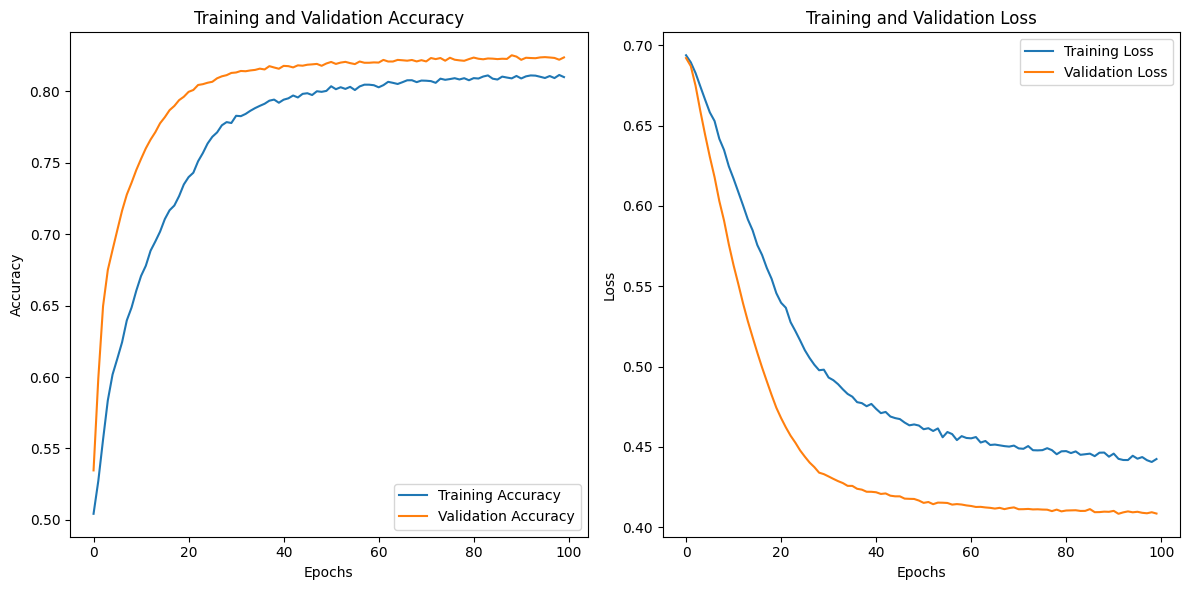

In [98]:
# Plot training accuracy and validation loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history_best.history['accuracy'], label='Training Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


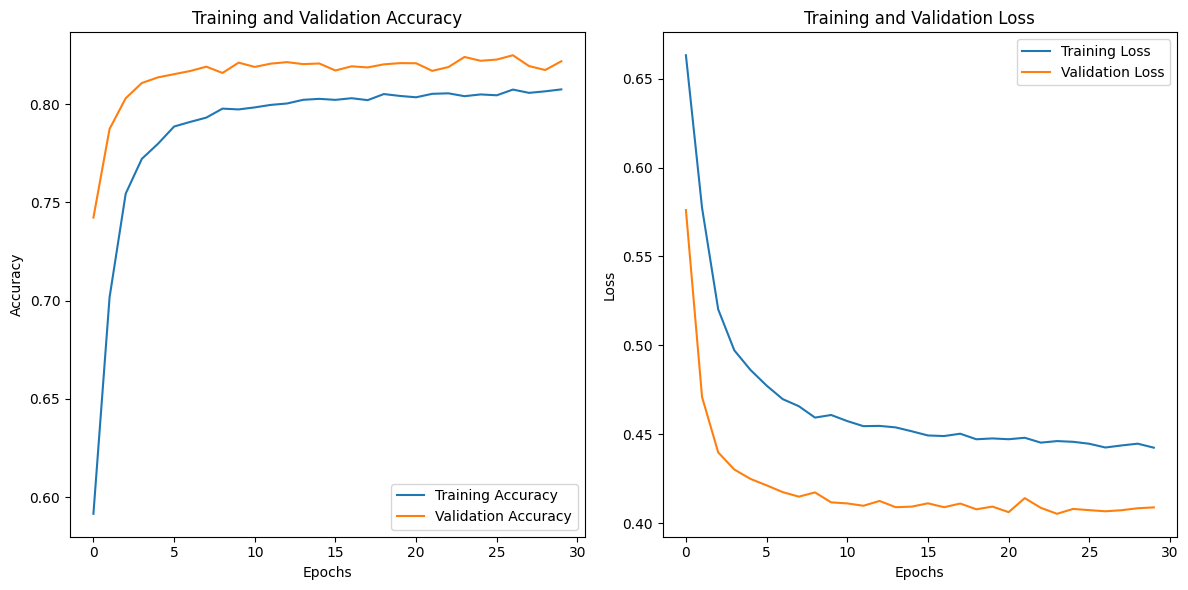

In [96]:
# Plot training accuracy and validation loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history_best.history['accuracy'], label='Training Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [89]:
model01 = Sequential()
model01.add(Dense(4, input_dim=768, activation='mish'))
model01.add(Dropout(0.3))  # Dropout to prevent overfitting

model01.add(Dense(4, activation='mish'))
model01.add(Dropout(0.3))  # Dropout to prevent overfitting

model01.add(Dense(4, activation='mish'))
model01.add(Dropout(0.3))  # Dropout to prevent overfitting

model01.add(Dense(4, activation='mish'))
model01.add(Dropout(0.3))  # Dropout to prevent overfitting

model01.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model01.add(Dense(1, activation='sigmoid'))

# Compile the model
model01.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=40,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


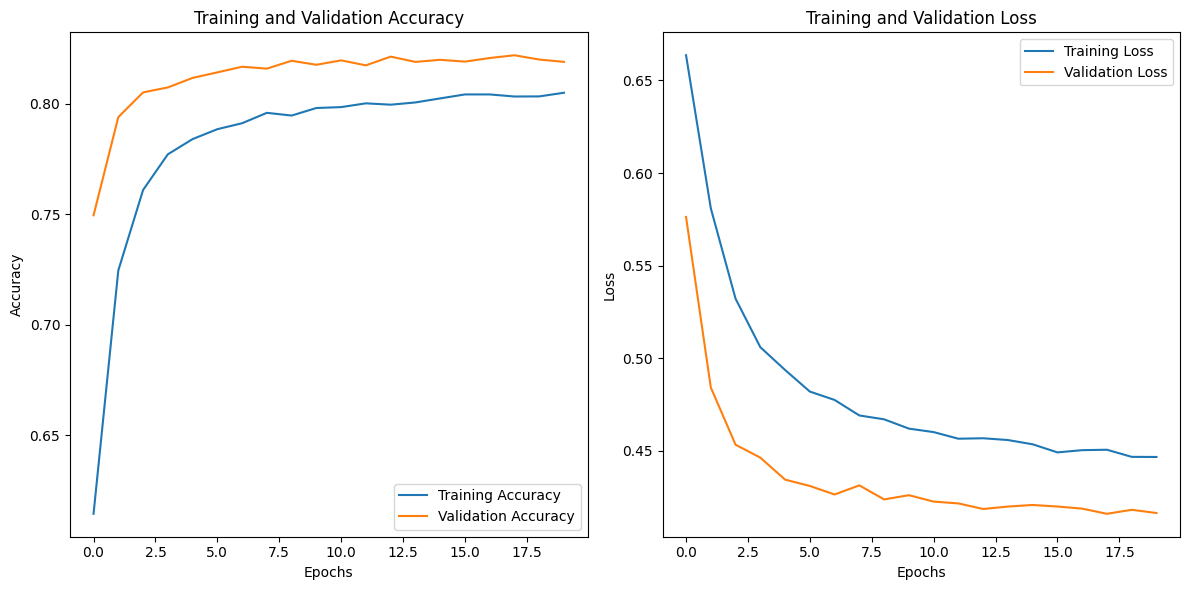

In [ ]:
history2 = model01.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Plot training accuracy and validation loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


Epoch 1/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5081 - loss: 0.7312 - val_accuracy: 0.5591 - val_loss: 0.6850
Epoch 2/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5415 - loss: 0.6915 - val_accuracy: 0.6513 - val_loss: 0.6682
Epoch 3/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5825 - loss: 0.6749 - val_accuracy: 0.7094 - val_loss: 0.6443
Epoch 4/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6195 - loss: 0.6613 - val_accuracy: 0.7359 - val_loss: 0.6136
Epoch 5/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6545 - loss: 0.6413 - val_accuracy: 0.7558 - val_loss: 0.5686
Epoch 6/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6874 - loss: 0.6163 - val_accuracy: 0.7746 - val_loss: 0.5278
Epoch 7/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7092 - loss: 0.5914 - val_accuracy: 0.7859 - val_loss: 0.4972
Epoch 8/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7314 - loss: 0.5666

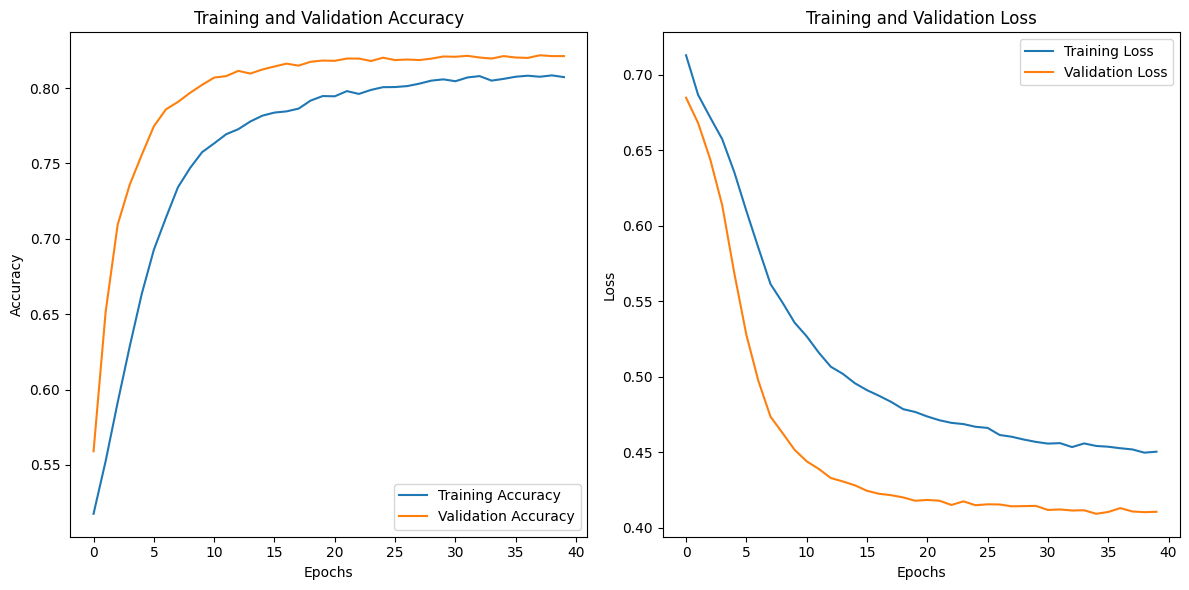

In [90]:
history2 = model01.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Plot training accuracy and validation loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [38]:
model16 = Sequential()
model16.add(Dense(16, input_dim=768, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(8, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model16.add(Dense(1, activation='sigmoid'))

# Compile the model
model16.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=100,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model16.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model16)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5480 - loss: 0.7273 - val_accuracy: 0.6973 - val_loss: 0.6108
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6566 - loss: 0.6187 - val_accuracy: 0.7419 - val_loss: 0.5476
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7053 - loss: 0.5686 - val_accuracy: 0.7671 - val_loss: 0.5041
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7361 - loss: 0.5295 - val_accuracy: 0.7799 - val_loss: 0.4773
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7520 - loss: 0.5089 - val_accuracy: 0.7887 - val_loss: 0.4586
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7701 - loss: 0.4843 - val_accuracy: 0.7961 - val_loss: 0.4455
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7801 - loss: 0.4734 - val_accuracy: 0.8021 - val_loss: 0.4348
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7894 - loss: 0

82.44500000000001

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [40]:
model17 = Sequential()
model17.add(Dense(16, input_dim=768, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(8, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model17.add(Dense(1, activation='sigmoid'))

# Compile the model
model17.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=52,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model17.fit(X_train, y_train, epochs=52, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model17)

Epoch 1/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5783 - loss: 0.6866 - val_accuracy: 0.7140 - val_loss: 0.5822
Epoch 2/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6747 - loss: 0.6025 - val_accuracy: 0.7511 - val_loss: 0.5291
Epoch 3/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7215 - loss: 0.5576 - val_accuracy: 0.7704 - val_loss: 0.4928
Epoch 4/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7473 - loss: 0.5283 - val_accuracy: 0.7786 - val_loss: 0.4698
Epoch 5/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7649 - loss: 0.5050 - val_accuracy: 0.7896 - val_loss: 0.4545
Epoch 6/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7752 - loss: 0.4889 - val_accuracy: 0.7953 - val_loss: 0.4437
Epoch 7/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7840 - loss: 0.4777 - val_accuracy: 0.8024 - val_loss: 0.4347
Epoch 8/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7908 - loss: 0.4626 

82.205

In [41]:
model18 = Sequential()
model18.add(Dense(16, input_dim=768, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(8, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model18.add(Dense(1, activation='sigmoid'))

# Compile the model
model18.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=100,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)


# Train the model
model18.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model18)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5616 - loss: 0.7180 - val_accuracy: 0.7013 - val_loss: 0.6084
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6734 - loss: 0.6170 - val_accuracy: 0.7351 - val_loss: 0.5588
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7080 - loss: 0.5715 - val_accuracy: 0.7573 - val_loss: 0.5112
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7283 - loss: 0.5393 - val_accuracy: 0.7759 - val_loss: 0.4821
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7550 - loss: 0.5105 - val_accuracy: 0.7846 - val_loss: 0.4615
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7742 - loss: 0.4883 - val_accuracy: 0.7944 - val_loss: 0.4488
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7840 - loss: 0.4765 - val_accuracy: 0.8026 - val_loss: 0.4392
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7909 - loss: 

82.44

In [42]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(512, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                patience=10,  # Number of epochs to wait before stopping if no improvement
                                restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                verbose=1)

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6363 - loss: 0.6366 - val_accuracy: 0.7804 - val_loss: 0.4694
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7771 - loss: 0.4750 - val_accuracy: 0.8034 - val_loss: 0.4327
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8046 - loss: 0.4303 - val_accuracy: 0.8101 - val_loss: 0.4158
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8145 - loss: 0.4091 - val_accuracy: 0.8149 - val_loss: 0.4069
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8255 - loss: 0.3901 - val_accuracy: 0.8187 - val_loss: 0.4055
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.8353 - loss: 0.3741 - val_accuracy: 0.8189 - val_loss: 0.4021
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8392 - loss: 0.3648 - val_accuracy: 0.8211 - val_loss: 0.3998
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8454 -

82.235

In [43]:
models = [model, model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14, model15, model16, model17, model18, modeli]

In [44]:
model_results = []

for Model in models:
    model_results.append((Model.count_params(), accuracy_val(Model)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


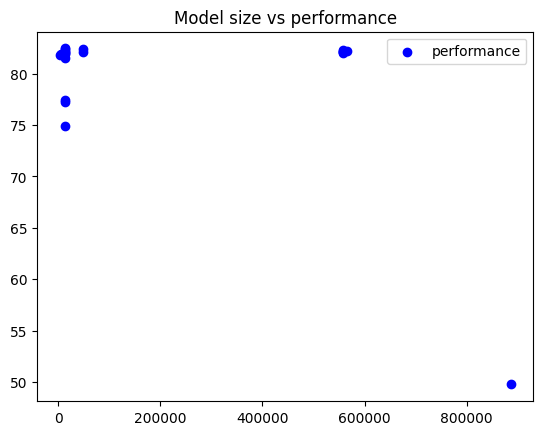

In [45]:
x,y = [], []

for Model in model_results:
    x.append(Model[0])
    y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


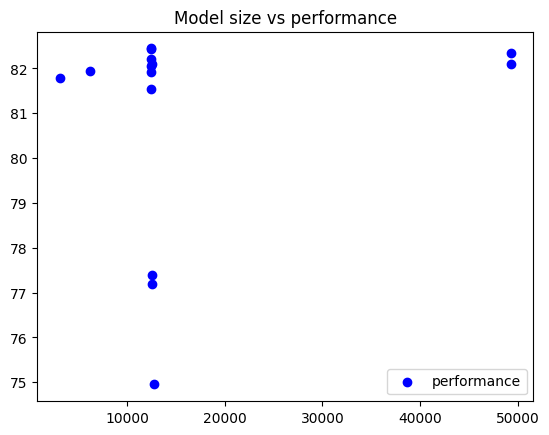

In [46]:
x,y = [], []

for Model in model_results:
    if (Model[0] < 100000):
        x.append(Model[0])
        y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


In [47]:
model_results

[(558081, 81.99),
 (558081, 82.235),
 (558081, 82.09),
 (558081, 82.14),
 (886529, 49.75),
 (558081, 82.27499999999999),
 (49281, 82.355),
 (49281, 82.095),
 (12593, 77.39),
 (12721, 74.95),
 (12593, 77.19),
 (12593, 82.09),
 (12481, 81.925),
 (12481, 82.045),
 (12481, 81.545),
 (6221, 81.95),
 (3149, 81.78),
 (12481, 82.44500000000001),
 (12481, 82.205),
 (12481, 82.44),
 (566273, 82.235)]

In [48]:
model_family = []

In [49]:
model_family.append(modeli)

In [50]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(256, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5998 - loss: 0.6680 - val_accuracy: 0.7684 - val_loss: 0.4883
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7601 - loss: 0.5018 - val_accuracy: 0.7961 - val_loss: 0.4427
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7926 - loss: 0.4537 - val_accuracy: 0.8066 - val_loss: 0.4229
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8069 - loss: 0.4263 - val_accuracy: 0.8144 - val_loss: 0.4129
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8145 - loss: 0.4131 - val_accuracy: 0.8186 - val_loss: 0.4063
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8220 - loss: 0.3957 - val_accuracy: 0.8192 - val_loss: 0.4030
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8283 - loss: 0.3865 - val_accuracy: 0.8198 - val_loss: 0.4005
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8356 -

82.235

### Results

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


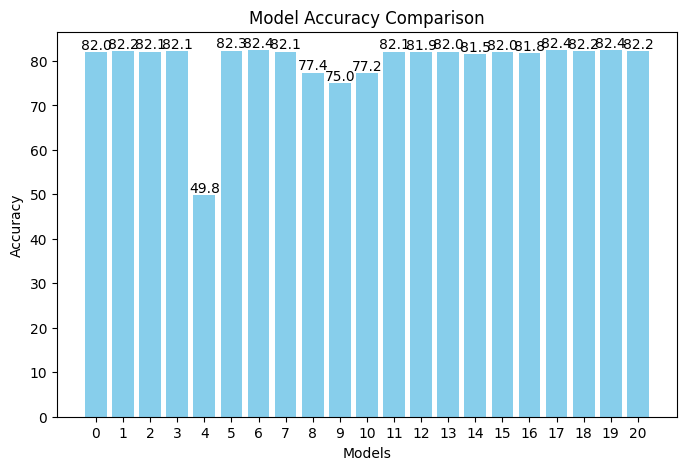

In [51]:
# Given list of models
models = [model, model0, model1, model2, model3, 
          model4, model5, model6, model7, model8, 
          model9, model10, model11, model12, model13, 
          model14, model15, model16, model17, model18, 
          modeli]

# Compute accuracy values
accuracies = [accuracy_val(m) for m in models]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(models))]

models_perf = pd.DataFrame({'model': models, 'accuracy': accuracies})

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Show values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.1f}", ha='center', va='bottom')

# Display the plot
plt.show()


In [68]:
accuracies

[81.99,
 82.235,
 82.09,
 82.14,
 49.75,
 82.27499999999999,
 82.355,
 82.095,
 77.39,
 74.95,
 77.19,
 82.09,
 81.925,
 82.045,
 81.545,
 81.95,
 81.78,
 82.44500000000001,
 82.205,
 82.44,
 82.235]

In [52]:
float(np.mean(accuracies))

79.76761904761904

In [53]:
float(np.median(accuracies))

82.09

In [67]:
float(np.std(accuracies))

7.005288583676591

In [54]:
(float(np.min(accuracies)), float(np.max(accuracies)))

(49.75, 82.44500000000001)

### Drop Models 4,8,9,10,15

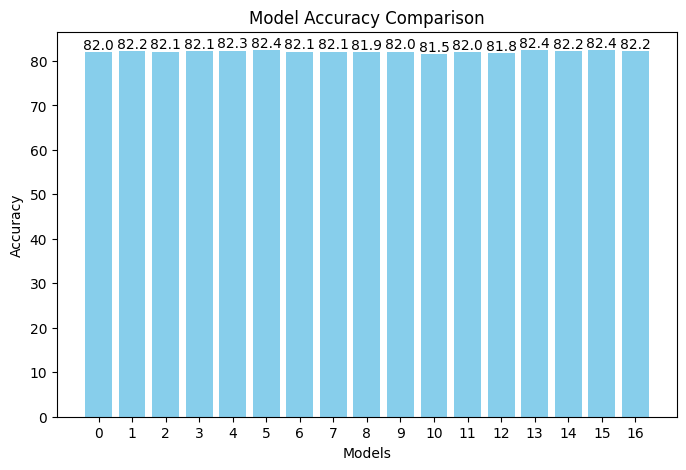

In [55]:
# Drop rows where accuracy is less than 0.80
good_models_perf = models_perf[models_perf['accuracy'] >= 80]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(good_models_perf))]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, good_models_perf.accuracy, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Show values on bars
for i, acc in enumerate(good_models_perf.accuracy):
    plt.text(i, acc, f"{acc:.1f}", ha='center', va='bottom')

# Display the plot
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


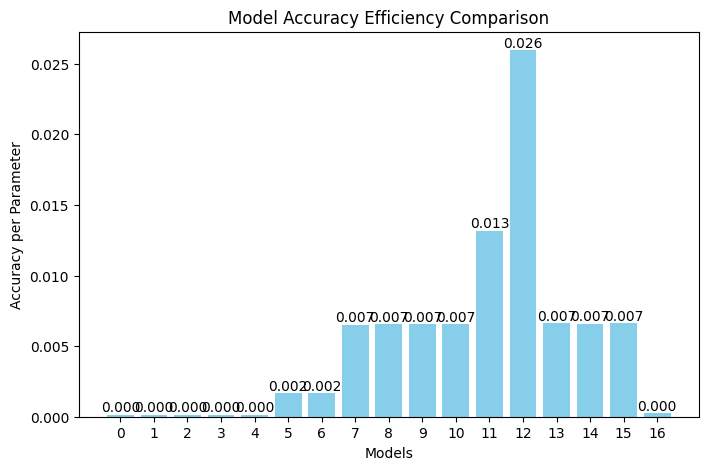

In [56]:
# Given list of models
remaining_models = good_models_perf.model

# Compute accuracy per parameter values
accuracy_efficiencies = [accuracy_val(m)/(m.count_params()) for m in remaining_models]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(remaining_models))]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracy_efficiencies, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy per Parameter")
plt.title("Model Accuracy Efficiency Comparison")

# Show values on bars
for i in range(len(accuracy_efficiencies)):
    acc = accuracy_efficiencies[i]
    plt.text(i, acc, f"{acc:.3f}", ha='center', va='bottom')

# Display the plot
plt.show()


In [69]:
accuracy_stats = [(accuracy_val(m),m.count_params()) for m in remaining_models]

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [57]:
def convert(y_predict):
    return np.array(list(map(lambda x: x[0], y_predict)))

In [58]:
model15.predict(X_test) > 0.5

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[False],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [59]:
metrics(y_test, convert(model15.predict(X_test) > 0.5), table = True, model_name="Neural Network")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


model  accuracy  precision  recall  f1_score
0  Neural Network    0.8178     0.8246  0.8057     0.815

In [60]:
remaining_models[accuracy_efficiencies.index(max(accuracy_efficiencies))]

<Sequential name=sequential_13, built=True>

In [61]:
model11

<Sequential name=sequential_13, built=True>

### Best Performing and Efficient Deep Neural Network

In [62]:
best_stats = (model15.count_params(), accuracy_train(model15), accuracy_val(model15))
print(f"Model has {best_stats[0]} parameters")
print(f"Model has train accuracy of {best_stats[1]}%,")
print(f"Model has test accuracy of {best_stats[2]}%,")

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model has 3149 parameters
Model has train accuracy of 82.6025%,
Model has test accuracy of 81.78%,


In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
y_pred3 = model15.predict(X_test) > 0.5
CM = confusion_matrix(y_test, y_pred3)
CM

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


array([[8327, 1708],
       [1936, 8029]])

In [65]:
metrics(y_test, y_pred3, table = True, model_name="Neural Network")

model  accuracy  precision  recall  f1_score
0  Neural Network    0.8178     0.8246  0.8057     0.815

## K-Means++ & Deep Learning Neural Network

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, tweets[0], test_size=0.2)

In [101]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
def sklearnKmeans_plus(X, k, m):
    '''
    X: numpy array, shape = [N, D]
    k: int value
    m: int value
    RETURN
        position: numpy array, shape = [N]
        centers: numpy array, shape = [k, D]
    '''
    position, centers = None, None
    ## start your code here
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=1, max_iter=m).fit(X)
    position, centers = kmeans.predict(X), kmeans.cluster_centers_
    
    # Compute WSS
    WSS = np.sum((X - centers[position])**2)
    
    return position, centers, WSS

In [103]:
cluster_assignments = {}  # Dictionary to store assigned data points

wss_values = []  # Store WSS for each k
k_values = list(range(1, 11))  # k from 1 to 30

for k in k_values:
    print(f"at {k} k-value now")
    position, centers, WSS = sklearnKmeans_plus(X_train, k, 1000)
    
    # Store the WSS value for plotting
    wss_values.append(WSS)

    # Store cluster assignments (optional for later)
    cluster_assignments[k] = {
        "positions": position,
        "centers": centers,
        "WSS": WSS
    }


at 1 k-value now
at 2 k-value now
at 3 k-value now
at 4 k-value now
at 5 k-value now
at 6 k-value now
at 7 k-value now
at 8 k-value now
at 9 k-value now
at 10 k-value now


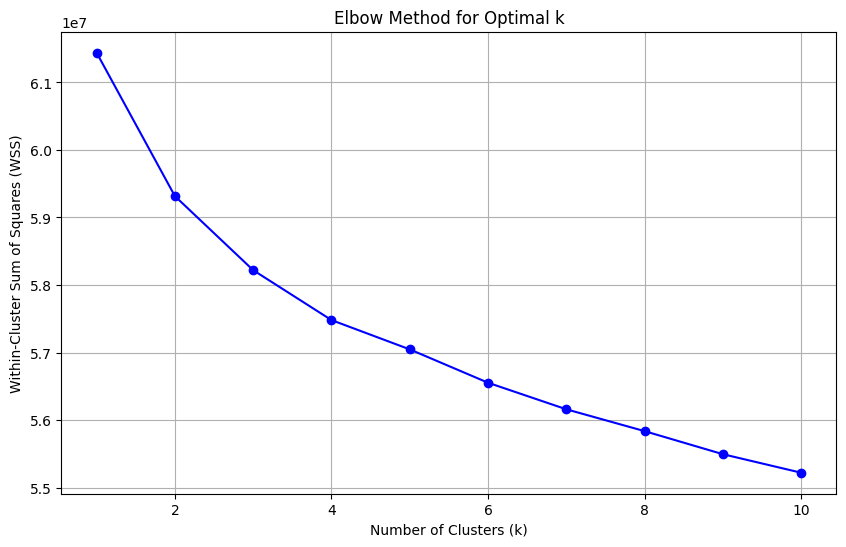

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linestyle='-', color='b')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)

plt.show()

Optimal k found at: 4


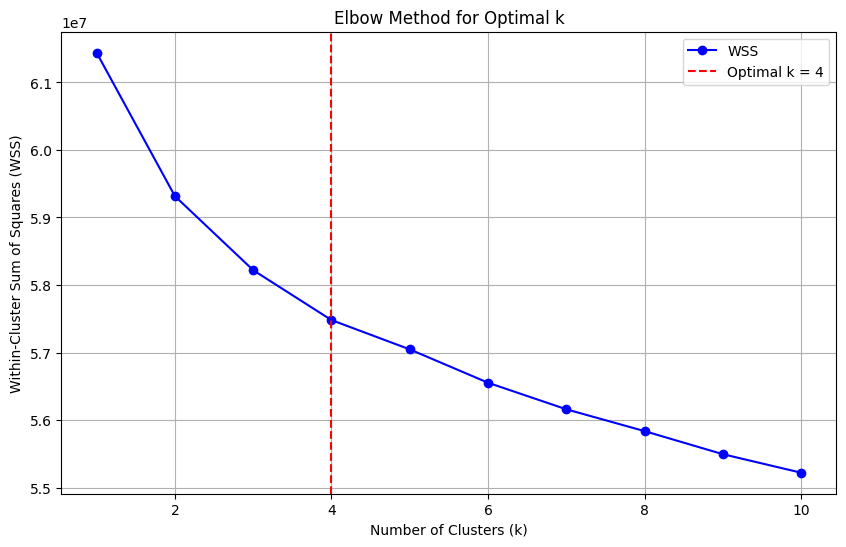

In [ ]:
from kneed import KneeLocator

knee_locator = KneeLocator(k_values, wss_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"Optimal k found at: {optimal_k}")

# Plot again with optimal k highlighted
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linestyle='-', color='b', label="WSS")
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid(True)

plt.show()


In [106]:

def train_dnn(X, Y, position, cluster):
    # Create a mask where the position matches the index
    mask = (position == cluster)

    # Apply mask to keep only the relevant Y values
    y_train = Y[mask]
    X_train = X[mask]
    
    # Remove zero entries
    X_train = X_train[~np.all(X_train == 0, axis=1)]
    y_train = y_train[~np.all(X_train == 0, axis=1)]  # Ensure y_train is aligned



    new_model = Sequential()
    new_model.add(Dense(4, input_dim=768, activation='mish'))
    new_model.add(Dropout(0.3))  # Dropout to prevent overfitting

    new_model.add(Dense(2, activation='mish'))
    new_model.add(Dropout(0.3))  # Dropout to prevent overfitting

    # Output layer: single neuron with sigmoid activation for binary classification
    new_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    new_model.compile(optimizer=AdamW(learning_rate=0.0005), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                   patience=100,  # Number of epochs to wait before stopping if no improvement
                                   restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                   verbose=1)

    # Train the model
    new_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

    return new_model

In [107]:
optimal_cluster = cluster_assignments[optimal_k]['positions']
optimal_cluster

array([3, 0, 3, ..., 2, 2, 1], dtype=int32)

In [108]:
count = [i for i in range(4)]
for i in range(4):
    count[i] = int(sum(optimal_cluster == i))
count

[18777, 22681, 24584, 13958]

In [ ]:
cluster_models = {}  # Dictionary to store cluster-wise DNN models

# Train a separate Deep Neural Network for each cluster
for cluster in range(4):
    cluster_models[cluster] = train_dnn(X_train, y_train, optimal_cluster, cluster)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5552 - loss: 0.7183 - val_accuracy: 0.6850 - val_loss: 0.6498
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6534 - loss: 0.6509 - val_accuracy: 0.7279 - val_loss: 0.6063
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6836 - loss: 0.6181 - val_accuracy: 0.7188 - val_loss: 0.5936
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6957 - loss: 0.5966 - val_accuracy: 0.7543 - val_loss: 0.5553
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7072 - loss: 0.5743 - val_accuracy: 0.7628 - val_loss: 0.5306
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7082 - loss: 0.5602 - val_accuracy: 0.7732 - val_loss: 0.5118
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7136 - loss: 0.5382 - val_accuracy: 0.7681 - val_loss: 0.5021
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7138 - loss: 0.5341 -

### Inner Cluster Model Evaluation

In [ ]:
cluster_models

{0: <Sequential name=sequential_30, built=True>,
 1: <Sequential name=sequential_31, built=True>,
 2: <Sequential name=sequential_32, built=True>,
 3: <Sequential name=sequential_33, built=True>}

In [ ]:
cluster_models[2].count_params()

3089

In [ ]:
k_values = [i for i in range(1, 12, 2)]
scores = []

for k in k_values:
    print(f"at {k} k-value now")
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, optimal_cluster, cv=5)
    scores.append(np.mean(score))

at 1 k-value now
at 3 k-value now
at 5 k-value now
at 7 k-value now
at 9 k-value now
at 11 k-value now


Text(0, 0.5, 'Cross-Validation Score')

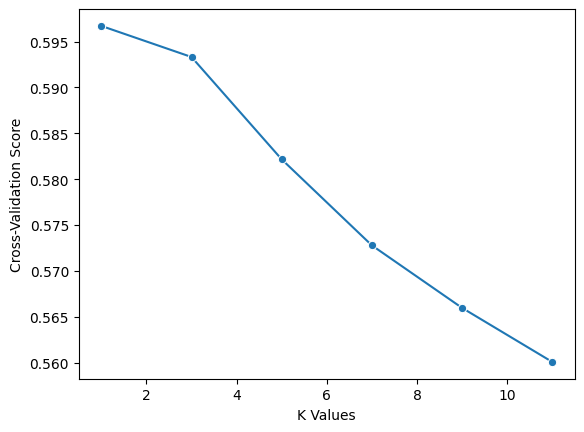

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Score")

In [ ]:
optimal_kneighbour = k_values[scores.index(max(scores))]

In [ ]:
knn = KNeighborsClassifier(n_neighbors=optimal_kneighbour)
knn.fit(X_train, optimal_cluster)
cluser_hat = knn.predict(X_test)

In [ ]:
N = len(y_test)
N

20000

In [ ]:
cluser_hat[0]

np.int32(3)

In [ ]:
X_test[0].shape

(768,)

In [ ]:

y_hat4 = [0 for i in range(N)]

for i in range(len(X_test)):
    x_i = X_test[i]
    cluster = cluser_hat[i]
    model = cluster_models[cluster]
    y_hat4[i] = model.predict(np.array([x_i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [ ]:
y_pred4 = (np.array(list(map(lambda x: x[0][0], y_hat4))) >= 0.5)

In [ ]:
float((sum((y_pred4 >= 0.5) == y_test)/len(y_test)))*100

81.0

## Results

In [ ]:
m1 = metrics(y_test, y_pred1, table = True, model_name="Random Forest")
m2 = metrics(y_test, y_pred2, table = True, model_name="K-NN")
m3 = metrics(y_test, y_pred3, table = True, model_name="Neural Network")
m4 = metrics(y_test, y_pred4, table = True, model_name="Custom NN")
final_results = pd.concat([m1,m2,m3,m4]).reset_index(drop=True)


In [ ]:
final_results

model  accuracy  precision  recall  f1_score
0   Random Forest    0.7181     0.7178  0.7199    0.7188
1            K-NN    0.4938     0.4944  0.5012    0.4978
2  Neural Network    0.8212     0.8213  0.8216    0.8214
3       Custom NN    0.4946     0.4946  0.4505    0.4715